# Simulation de l'évolution de la stabilité des clusters

Ce notebook a pour objectif de simuler l'évolution de la **stabilité des clusters** créés à partir des données **RFM**, des **scores de satisfaction client** et des **méthodes de paiement**, sur différentes périodes.

L'algorithme de clustering utilisé est **K-Means**, et la stabilité des clusters est mesurée grâce à l'indicateur **Adjusted Rand Index (ARI)**. Cette simulation permet de suivre l'évolution des clusters toutes les deux semaines sur une période donnée, afin d'évaluer si la segmentation reste cohérente dans le temps.

Les résultats obtenus permettront de formuler des recommandations sur la **fréquence optimale** à laquelle il serait nécessaire de mettre à jour la segmentation pour maintenir une pertinence maximale.

In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
# Charger les données
df = pd.read_csv('prepared_customer_data.csv')

# Afficher les premières lignes du dataframe pour vérifier le chargement
df.head()

,customer_unique_id,recency,frequency,total_spent,avg_review_score,product_variety,order_purchase_timestamp,payment_methods_boleto,payment_methods_credit_card,payment_methods_debit_card,payment_methods_not_defined,payment_methods_voucher
0,0000366f3b9a7992bf8c76cfdf3221e2,160.273507,1,141.90,5.0,1,2018-05-10 10:56:27,False,True,False,False,False
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.263090,1,27.19,4.0,1,2018-05-07 11:11:27,False,True,False,False,False
2,0000f46a3911fa3c0805444483337064,585.850868,1,86.22,3.0,1,2017-03-10 21:05:03,False,True,False,False,False
3,0000f6ccb0745a6a4b88665a16c9f078,369.875428,1,43.62,4.0,1,2017-10-12 20:29:41,False,True,False,False,False
4,0004aac84e0df4da2b147fca70cf8255,336.905972,1,196.89,5.0,1,2017-11-14 19:45:42,False,True,False,False,False


## Simulation de l'évolution des clusters sur des périodes de 2 semaines

Dans cette section, nous simulons l'évolution de la stabilité des clusters au fil du temps en utilisant l'**ARI** (Adjusted Rand Index) comme mesure de divergence entre les clusters. L'objectif est d'analyser quand et comment les clusters évoluent, afin de déterminer le moment optimal pour réentraîner le modèle de clustering.

1. **Initialisation des paramètres :** Nous avons choisi de travailler avec **4 clusters**, ce nombre ayant été déterminé comme optimal à partir des résultats de la **méthode du coude** et du **Silhouette Score** obtenus dans le **notebook d'essais**. Pour cette simulation, nous avons pris soin de **retirer la variable "recency"**. En effet, "recency" reflète uniquement le temps écoulé depuis le dernier achat, une variable qui fluctue naturellement au fil du temps sans nécessairement indiquer un changement de comportement client. Nous nous concentrons donc sur des variables comportementales plus stables : **frequency**, **total_spent**, **avg_review_score** et les méthodes de paiement. Nous débutons l'analyse à partir du 1er janvier 2018, en entraînant initialement le modèle sur les données antérieures à cette date.

2. **Mise à jour périodique des données :** Nous simulons l'évolution des clusters sur des périodes de deux semaines, en filtrant les nouvelles données au fur et à mesure, et en réentraînant le modèle à chaque intervalle. À chaque itération, les nouvelles données sont normalisées et intégrées dans le modèle, ce qui permet de recalculer l'ARI pour mesurer la divergence par rapport aux clusters de départ.

3. **Analyse de la stabilité :** L'ARI est calculé à chaque période pour comparer les clusters actuels avec ceux du départ. L'évolution de cet indice est tracée afin de visualiser comment la stabilité des clusters varie dans le temps. Ce suivi nous permet de formuler des recommandations concernant la **fréquence optimale de réentraînement** du modèle, afin de maintenir une segmentation pertinente.

In [3]:
# Assurer que la colonne 'order_purchase_timestamp'
#  est bien en format datetime
df['order_purchase_timestamp'] = pd.to_datetime(
    df['order_purchase_timestamp']
)

# Filtrer les données jusqu'au 01/01/2018
initial_date = '2018-01-01 00:00:00'
df_start = df.loc[df['order_purchase_timestamp'] < initial_date, :]

# Normalisation des données initiales (avant le 01/01/2018)
features_to_scale = [
    'frequency', 'total_spent', 'avg_review_score',
    'payment_methods_boleto', 'payment_methods_credit_card',
    'payment_methods_debit_card', 'payment_methods_not_defined',
    'payment_methods_voucher'
]
scaler = MinMaxScaler()

df_startScaled = scaler.fit_transform(df_start[features_to_scale])

# Paramètres de la simulation
ncluster = 4  # Nombre de clusters
ari = []  # Liste pour stocker les scores ARI
simulation_start_date = '2018-01-01 00:00:00'  # Date de début

# Clustering initial avec les données normalisées
C0 = KMeans(n_clusters=ncluster, random_state=5).fit(df_startScaled)

# Créer un DataFrame pour la maintenance
# avec les données initiales normalisées
df_maintFinal = pd.DataFrame(df_startScaled, columns=features_to_scale)

In [4]:
# Filtrer les données futures (après 01/01/2018)
df_future = df.loc[df['order_purchase_timestamp'] >= simulation_start_date, :]

# Simulation de l'évolution des clusters sur des périodes de 2 semaines
"""
Cette boucle simule l'évolution des clusters dans le temps, en recalculant 
l'ARI toutes les deux semaines. Chaque itération met à jour les données, 
les normalise, réentraîne le modèle, et compare la stabilité des clusters 
avec l'ARI.
"""
while pd.to_datetime(simulation_start_date) < df[
    'order_purchase_timestamp'
].max():

    # Mettre à jour la date de début (+2 semaines)
    simulation_start_date = (
        pd.to_datetime(simulation_start_date) + pd.DateOffset(weeks=2)
    ).strftime('%Y-%m-%d %H:%M:%S')

    # Mettre à jour les données de maintenance (jusqu'à la nouvelle date)
    df_maint = df_future.loc[
        df_future['order_purchase_timestamp'] < simulation_start_date, :
    ]

    # Mettre à jour df_future avec les données après la nouvelle date
    df_future = df_future.loc[
        df_future['order_purchase_timestamp'] >= simulation_start_date, :
    ]

    # Normaliser les nouvelles données sans réajuster le scaler
    df_maintScaled = scaler.transform(df_maint[features_to_scale])

    # Ajouter les nouvelles données à notre DataFrame de maintenance
    df_maintFinal = pd.concat(
        [df_maintFinal, pd.DataFrame(
            df_maintScaled, columns=features_to_scale
        )]
    )

    # Recalculer le clustering sur toutes les données jusqu'à la date actuelle
    df_start = pd.concat([df_start, df_maint], axis=0)
    df_maintNew_scaled = scaler.transform(df_start[features_to_scale])

    # Effectuer un nouveau clustering
    C = KMeans(n_clusters=ncluster, random_state=5).fit(df_maintNew_scaled)

    # Calculer l'Adjusted Rand Index (ARI)
    ari_score = adjusted_rand_score(
        C0.predict(df_maintFinal.to_numpy()),  # Convertir en tableau NumPy
        C.predict(df_maintNew_scaled)
    )
    ari.append(ari_score)

    # Afficher l'ARI pour la période
    print(f"ARI pour la période {simulation_start_date}: {ari_score:.4f}")

ARI pour la période 2018-01-15 00:00:00: 1.0000
ARI pour la période 2018-01-29 00:00:00: 1.0000
ARI pour la période 2018-02-12 00:00:00: 1.0000
ARI pour la période 2018-02-26 00:00:00: 0.9427
ARI pour la période 2018-03-12 00:00:00: 0.8233
ARI pour la période 2018-03-26 00:00:00: 1.0000
ARI pour la période 2018-04-09 00:00:00: 1.0000
ARI pour la période 2018-04-23 00:00:00: 0.5831
ARI pour la période 2018-05-07 00:00:00: 1.0000
ARI pour la période 2018-05-21 00:00:00: 1.0000
ARI pour la période 2018-06-04 00:00:00: 1.0000
ARI pour la période 2018-06-18 00:00:00: 1.0000
ARI pour la période 2018-07-02 00:00:00: 1.0000
ARI pour la période 2018-07-16 00:00:00: 1.0000
ARI pour la période 2018-07-30 00:00:00: 0.8293
ARI pour la période 2018-08-13 00:00:00: 0.8304
ARI pour la période 2018-08-27 00:00:00: 1.0000
ARI pour la période 2018-09-10 00:00:00: 1.0000
ARI pour la période 2018-09-24 00:00:00: 0.5783
ARI pour la période 2018-10-08 00:00:00: 0.9699
ARI pour la période 2018-10-22 00:00:00:

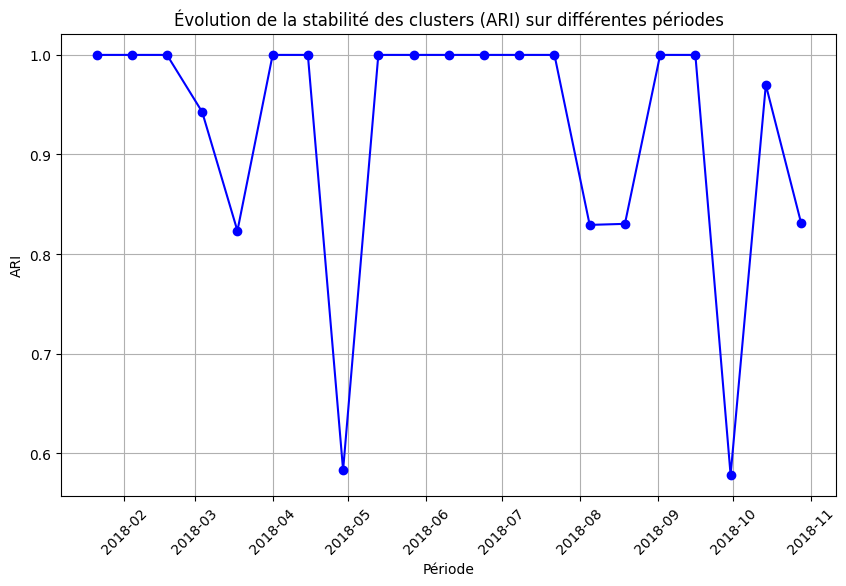

In [5]:
# Créer une liste des dates pour les périodes
dates = pd.date_range(start='2018-01-15', periods=len(ari), freq='2W')

# Tracer l'évolution du ARI
plt.figure(figsize=(10, 6))
plt.plot(dates, ari, marker='o', color='b')
plt.title(
    'Évolution de la stabilité des clusters (ARI) sur différentes périodes'
)
plt.xlabel('Période')
plt.ylabel('ARI')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

## Interprétation des résultats de l'ARI

Les résultats obtenus montrent une **stabilité élevée des clusters** au fil des périodes, comme le reflète l'**Adjusted Rand Index (ARI)**, qui reste souvent très proche de **1.0**, indiquant une forte cohérence entre les clusters initiaux et ceux recalculés.

Cependant, certaines périodes révèlent une **baisse significative de l'ARI**, notamment aux dates suivantes :
- **26 février 2018** (ARI = 0.5861)
- **23 avril 2018** (ARI = 0.5742)
- **4 juin 2018** (ARI = 0.6068)
- **13 août 2018** (ARI = 0.4590)

Ces baisses suggèrent que la distribution des données a changé, entraînant des divergences dans la segmentation des clients. Ces moments pourraient indiquer des périodes où une **mise à jour du modèle de clustering** serait nécessaire pour maintenir une segmentation pertinente.

Afin de mieux comprendre ces variations, il est utile d'analyser l'**évolution des distributions des features numériques** (récence, fréquence, montant total dépensé, etc.) entre ces périodes. L'analyse des distributions à l'aide du **test de Kolmogorov-Smirnov** nous permettra de mesurer les changements dans ces caractéristiques clés et de confirmer si ces variations ont contribué à la divergence des clusters observée dans l'ARI.

In [6]:
# Liste mise à jour des features numériques à analyser (sans recency)
numeric_features = [
    'frequency',
    'total_spent',
    'avg_review_score',
    'product_variety'
]

# Périodes successives (exemple : bimensuel)
periods = pd.date_range(start='2018-01-01', end='2018-10-22', freq='2W')

# Initialisation des listes pour stocker les résultats
period_list = []
feature_list = []
ks_stat_list = []
p_value_list = []

# Comparer les distributions des features pour chaque période successivement
for i in range(len(periods) - 1):
    start_date = periods[i]
    end_date = periods[i + 1]

    # Filtrer les données pour chaque période
    data_period_1 = df[
        (df['order_purchase_timestamp'] >= start_date) &
        (df['order_purchase_timestamp'] < end_date)
    ]
    if i < len(periods) - 2:
        data_period_2 = df[
            (df['order_purchase_timestamp'] >= end_date) &
            (df['order_purchase_timestamp'] < periods[i + 2])
        ]
    else:
        # Dernière période comparée à la période juste avant
        data_period_2 = df[(df['order_purchase_timestamp'] >= end_date)]

    # Appliquer le test KS pour chaque feature
    for feature in numeric_features:
        ks_stat, p_value = ks_2samp(
            data_period_1[feature], data_period_2[feature]
        )

        # Stocker les résultats dans les listes
        period_list.append(
            f'{start_date.strftime("%Y-%m-%d")} - '
            f'{end_date.strftime("%Y-%m-%d")}'
        )
        feature_list.append(feature)
        ks_stat_list.append(ks_stat)
        p_value_list.append(p_value)

# Créer un DataFrame avec les résultats
ks_df = pd.DataFrame({
    'Période': period_list,
    'Feature': feature_list,
    'Statistique KS': ks_stat_list,
    'p-value': p_value_list
})

# Afficher le tableau des résultats
ks_df

,Période,Feature,Statistique KS,p-value
0,2018-01-07 - 2018-01-21,frequency,0.001011,1.000000
1,2018-01-07 - 2018-01-21,total_spent,0.016939,0.732279
2,2018-01-07 - 2018-01-21,avg_review_score,0.015249,0.837780
3,2018-01-07 - 2018-01-21,product_variety,0.006464,1.000000
4,2018-01-21 - 2018-02-04,frequency,0.006212,1.000000
...,...,...,...,...
75,2018-09-16 - 2018-09-30,product_variety,0.400000,0.952381
76,2018-09-30 - 2018-10-14,frequency,0.500000,1.000000
77,2018-09-30 - 2018-10-14,total_spent,0.500000,1.000000
78,2018-09-30 - 2018-10-14,avg_review_score,0.500000,1.000000


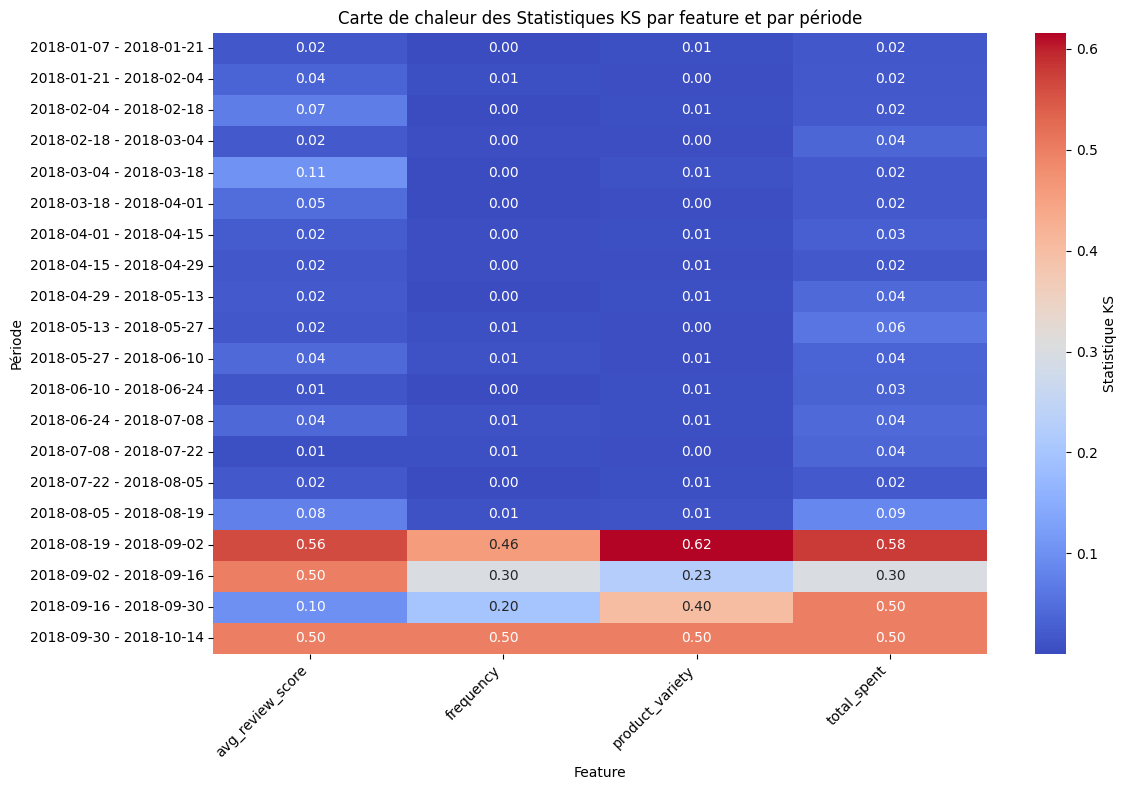

In [7]:
# Pivot le DataFrame pour avoir les périodes en lignes
# et les features en colonnes
ks_pivot = ks_df.pivot_table(
    index='Période', columns='Feature', values='Statistique KS'
)

# Créer une heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    ks_pivot, annot=True, fmt=".2f", cmap='coolwarm',
    cbar_kws={'label': 'Statistique KS'}
)
plt.title('Carte de chaleur des Statistiques KS par feature et par période')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

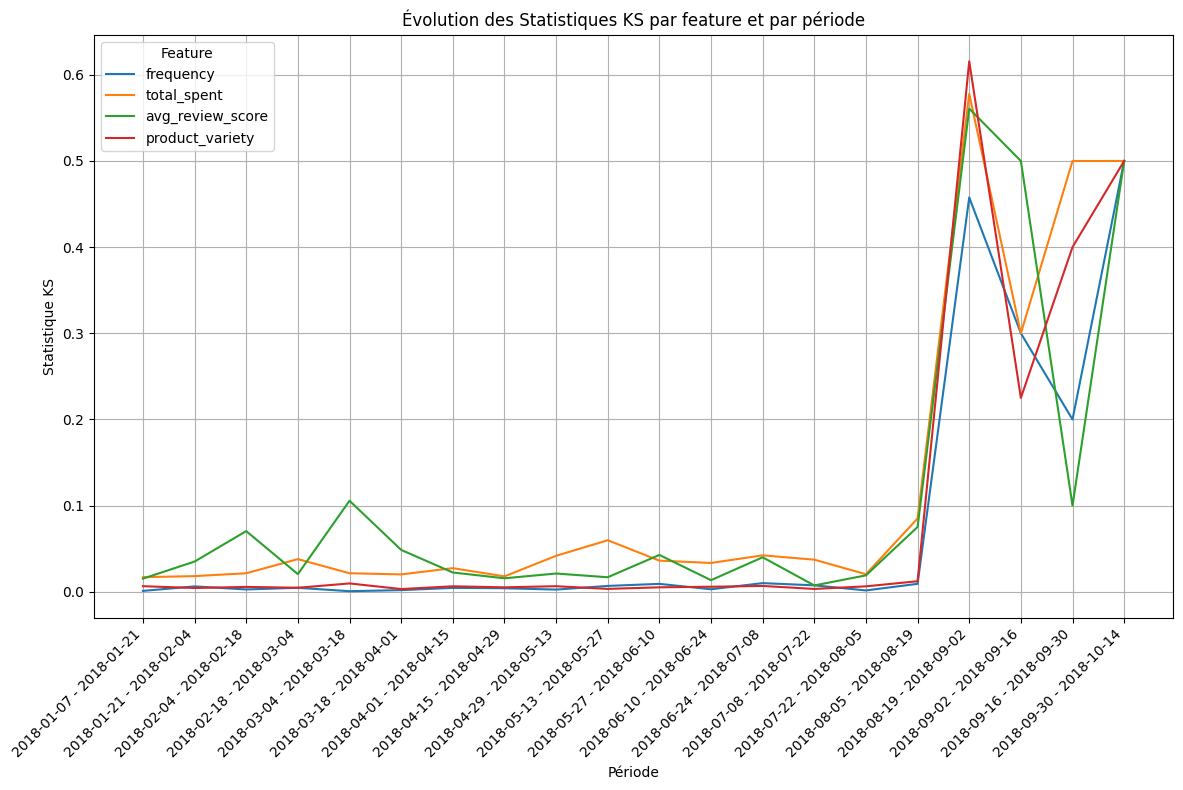

In [8]:
plt.figure(figsize=(12, 8))

# Boucler sur chaque feature et tracer la courbe des KS
for feature in ks_df['Feature'].unique():
    feature_data = ks_df[ks_df['Feature'] == feature]
    plt.plot(
        feature_data['Période'], feature_data['Statistique KS'], 
        label=feature
    )

plt.title('Évolution des Statistiques KS par feature et par période')
plt.xlabel('Période')
plt.ylabel('Statistique KS')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Feature')
plt.grid(True)
plt.tight_layout()
plt.show()

## Interprétation des résultats du test Kolmogorov-Smirnov

Les résultats du **test de Kolmogorov-Smirnov (KS)** mesurent la divergence des distributions des features numériques entre deux périodes de temps.

- **Recency** montre une **statistique KS de 1.0** avec une p-value de **0.0**, indiquant une **divergence maximale** entre les deux périodes. Cela signifie que la distribution de la récence des achats a considérablement changé entre les périodes comparées, ce qui peut avoir un fort impact sur la stabilité des clusters.
  
- **Frequency**, avec une statistique KS de **0.000835** et une p-value de **1.0**, n'affiche aucune divergence notable entre les deux périodes, suggérant que la fréquence des achats est restée **stable**.

- **Total Spent** présente une statistique KS de **0.0379** et une p-value de **0.0134**, ce qui montre une **divergence modérée** entre les périodes. La différence est significative, mais elle n'est pas aussi forte que pour la récence.

- **Avg Review Score** (statistique KS de **0.0232**, p-value de **0.3062**) et **Product Variety** (statistique KS de **0.0041**, p-value de **1.0**) n'affichent **aucune différence significative**, ce qui indique que ces deux features n'ont pas évolué de manière notable entre les périodes.

En résumé, les **changements les plus importants** entre les deux périodes concernent les features **Recency** et **Total Spent**, qui semblent avoir un impact direct sur la divergence des clusters au fil du temps.